### Thinkful Data Science Bootcamp

### Supervised Machine Learning Capstone

Emile Badran
June 4th, 2018

In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import time
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline
import scikitplot as skplt
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


# Predicting Crime in Chicago

This experiment applies supervised machine learning models to predict crime at specific locations and times in Chicago.

Law Enforcement Agencies can make use of future crime level probability calculations to optimize the allocation of policing resources. For example, by having a better understanding of when and where crime levels are highest, police can better plan their patrols and the locations where patrol cars are stationed.

**Primary research question:** Can future crime be predicted based on historical crime and weather data?

**Secondary research question:** Are there correlations between crime levels and a location's demographic data, such as household income, population size, and median age?

### Load updated Chicago crime data
The Chicago Crime dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2015 to present, minus the most recent seven days. Data is extracted from the Chicago Police Department's CLEAR ([Citizen Law Enforcement Analysis and Reporting](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2/data)) system.

In [2]:
# Read Chicago Crime Data file from a Google Cloud bucket:
import google.datalab.storage as storage
from io import BytesIO

In [3]:
# instantiate the bucket and file address
mybucket = storage.Bucket('la-data')
data_file = mybucket.object('Crimes_-_2015_to_present.csv')

# extract data from bucket in binary format
uri = data_file.uri

In [4]:
%gcs read --object $uri --variable csv_as_bytes

In [5]:
# read data into a Pandas dataframe
raw_data = pd.read_csv(BytesIO(csv_as_bytes), parse_dates=['Date'])

# rename columns
raw_data.columns = ['date', 'primary_type', 'community_area', 'year']

# create a crime count column setting all values to 1
raw_data['crime_count'] = 1

# preview the first five rows of the dataframe
raw_data.head()

,date,primary_type,community_area,year,crime_count
0,2015-03-18 19:44:00,BATTERY,25,2015,1
1,2015-03-18 23:00:00,OTHER OFFENSE,67,2015,1
2,2015-03-18 22:45:00,BATTERY,39,2015,1
3,2015-03-18 22:30:00,BATTERY,40,2015,1
4,2015-03-18 21:00:00,ROBBERY,25,2015,1


In [6]:
# inspect the number of observations in the data set
print('Data set shape before filtering:', raw_data.shape)

# filter non-criminal events
raw_data = raw_data[(raw_data.primary_type != 'NON - CRIMINAL') &
                     (raw_data.primary_type != 'NON-CRIMINAL') &
                     (raw_data.primary_type != 'NON-CRIMINAL (SUBJECT SPECIFIED)') &
                    (raw_data.community_area != 0)]

# only a few data points were deleted
print('Data set shape after filtering:', raw_data.shape)

Data set shape before filtering: (895477, 5)
Data set shape after filtering: (895327, 5)


### Load updated Chicago weather data
Chicago's Weather Data are collected by automated sensors at Weather Stations located at the City's beaches. The data set can be downloaded from the City's [official website](https://data.cityofpred_funcicago.org/Parks-Recreation/Beapred_func-Weather-Stations-Automated-Sensors/k7hf-8y75/data).

In [7]:
# instantiate the url
url = 'https://data.cityofchicago.org/api/views/k7hf-8y75/rows.csv?accessType=DOWNLOAD'

# read the data from the url to a Pandas dataframe
weather = pd.read_csv(url, parse_dates=['Measurement Timestamp'],
                              usecols=['Station Name','Air Temperature','Rain Intensity',
                                      'Wind Speed','Measurement Timestamp'])

# filter data from one of the weather stations
weather = weather[weather['Station Name']=='63rd Street Weather Station']

# drop unnecessary columns
weather.drop(columns='Station Name', inplace=True)

# delete incomplete observations prior to 2015-06-23
weather = weather[weather['Measurement Timestamp']>='2015-06-23']

# round timestamps to the lowest 4-hour value
weather['Measurement Timestamp'] = weather['Measurement Timestamp'].dt.floor('4H')

# assign the average value to observations within the same 4-hour time period
weather = weather.groupby(weather['Measurement Timestamp']).mean()

# create a list of timestamps within the dataset's date range
date_range = pd.date_range(weather.index.min(),
                           weather.index.max(), freq='4H')

# create rows with missing observations
weather = weather.loc[date_range]

# fill missing data with the next available observation
weather.fillna(method='ffill', inplace=True)

# delete data prior to 2018-05-24 8PM
weather = weather[weather.index <= '2018-05-24 20:00:00']

# inspect the resulting dataframe
print('Weather data start date:', weather.index.min())
print('Weather data end date:', weather.index.max())
weather.head(2)

Weather data start date: 2015-06-23 00:00:00
Weather data end date: 2018-05-24 20:00:00


,Air Temperature,Rain Intensity,Wind Speed
2015-06-23 00:00:00,24.75,0.0,2.55
2015-06-23 04:00:00,21.70,0.0,3.50


#### Weather Data Variable Metadata
- **Air Temperature -** Current air temperature measured in degrees Celsius
- **Rain Intensity -** Current rainfall measured in milimeters per hour
- **Wind Speed -** Current windspeed measured in meters per second

### Load and Scale Chicago Demographic Data
Demographic Data on Chicago Community Areas were obtained from the American Community Survey of 2006-2010 and from the decennial Census. The data sets can be downloaded from this [website](http://robparal.blogspot.com/2012/05/hard-to-find-census-data-on-chicago.html).

To improve model performance, the data set is standardized to have a mean of zero and a standard deviation of one.

In [8]:
# read CSV file
pop_data = pd.read_csv('5_chicago_hh_income_pop.csv',header=[1], index_col=0)

# Create a data frame and standardize all continuous variables
scaled_pop_data = pd.DataFrame(data=preprocessing.scale(pop_data),
                           columns=pop_data.columns, index=pop_data.index)

scaled_pop_data.head(2)

,Total Population,Median Age,Average Household Size,Vacant Housing Units,Renter occupied,Median household income
CHGOCA,,,,,,
1,0.897945,-0.342922,-0.963798,0.800281,1.426774,-0.363231
2,1.659636,0.239541,0.277674,0.465196,0.748967,0.085920


#### Demographic Data Variable Metadata
- **CHGOCA -** Community area code
- **Total Population -** Total population at each Community Area
- **Median Age -** Median age of Community Area residents
- **Average Household Size -** Measured in squared meters
- **Vacant Housing Units -** Total number of vacant homes
- **Renter Occupied -** Total number of homes occupied by tenants who pay rent (as opposed to occupied by home owners)
- **Median Household Income -** The median household income at the Community Area. The household income is the sum of the income of all home residents

## Chicago Community Areas
The Chicago Community Areas are 77 divisions of Chicago defined by the Social Science Research Committee at the University of Chicago. They are officially recognized by the City of Chicago. Each area is assigned with a numerical code.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Community_areas_in_Chicago)

<img src='ch_comm_areas.png' width=350px>

## Data Exploration

To understand the locations and times where crime is concentrated in Chicago, the data is analyzed from a time series perspective. Crime data was filtered for the year of 2017 and the frequencies of crime events were plotted by Community Area, crime type, month, day of the month, weekday, and hour.

In [9]:
# filter 2017 data into a variable
data_17 = raw_data[raw_data.date.dt.year == 2017]

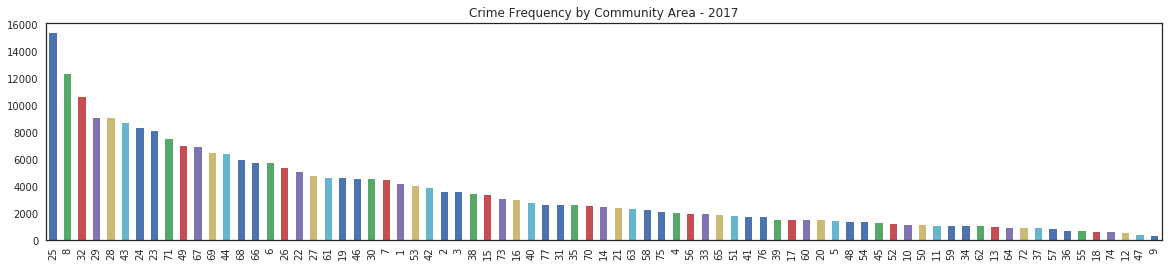

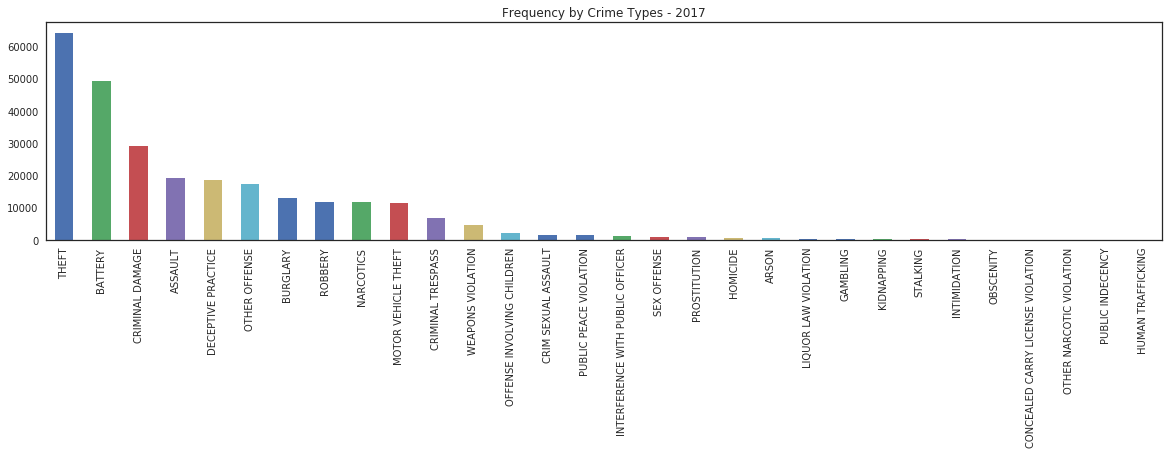

In [10]:
# plot crime frequency by community area
data_17.community_area.value_counts().plot.bar(figsize=(20,4), title='Crime Frequency by Community Area - 2017')
plt.show()

# plot crime frequency by crime types
data_17.primary_type.value_counts().plot.bar(figsize=(20,4), title='Frequency by Crime Types - 2017')
plt.show()

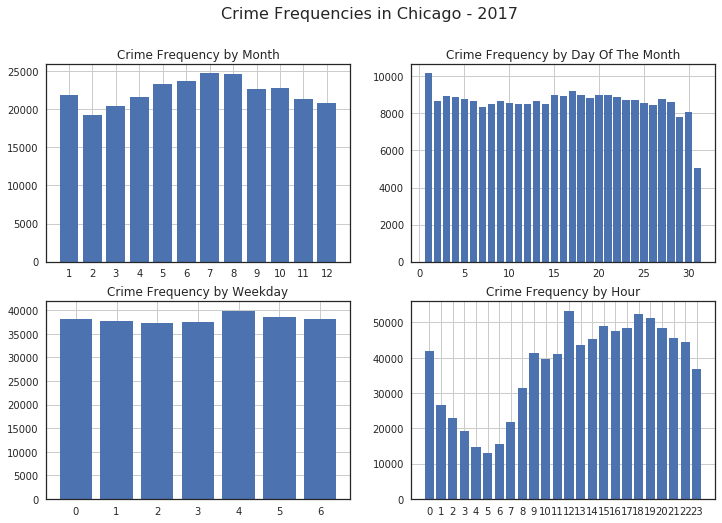

In [11]:
# instantiate a 2x2 grid of plots
plt.subplots(2,2, figsize=(12,8))

# define the overall plot titles
plt.suptitle('Crime Frequencies in Chicago - 2017', fontsize=16)

# generate graphs with crime frequency by different time periods
plt.subplot(221)
plt.bar(range(1,13), data_17['crime_count'].groupby(
    data_17.date.dt.month).sum().values)
plt.title('Crime Frequency by Month')
plt.xticks(range(1,13))
plt.grid(True)

plt.subplot(222)
plt.bar(range(1,32), data_17['crime_count'].groupby(
    data_17.date.dt.day).sum().values)
plt.title('Crime Frequency by Day Of The Month')
plt.grid(True)
 
plt.subplot(223)
plt.bar(range(0,7), data_17['crime_count'].groupby(
    data_17.date.dt.weekday).sum().values)
plt.title('Crime Frequency by Weekday')
plt.xticks(range(0,7))
plt.grid(True)
 
plt.subplot(224)
x_vals = range(0,24)
plt.bar(x_vals, raw_data['crime_count'].groupby(
    raw_data.date.dt.hour).sum().values)
plt.title('Crime Frequency by Hour')
plt.xticks(x_vals)
plt.grid(True)

plt.show()

## Group crime counts by periods of four hours and create classes
Since Police Departments generally plan patrols according to rosters and shifts, crime counts are calculated by periods of four hours totalling six periods:
- 00:00 to 03:59
- 04:00 to 07:59
- 08:00 to 11:59
- 12:00 to 15:59
- 16:00 to 19:59
- 20:00 to 23:59

The periods were selected to reflect existing patterns in crime frequencies (e.g., lower crime in the night, and higher crime at mid-day).

In [12]:
# Create a dataframe with selected columns
grouped_data = raw_data[['date', 'community_area', 'crime_count']].copy()

# Filter crime events to the same time frame of the available weather data
grouped_data = grouped_data[grouped_data.date >='2015-06-23']

# Round times to the lower 4-hour period
grouped_data.date = grouped_data.date.dt.floor('4H')

# Store the frequency of crime per month and weekday in a dictionary, for later use
# Instantiate the dictionary and loop for every Community Area
d = {}
for i in grouped_data.community_area.unique():

    # Create a nested dictionary with the frequency of crime counts per month for each Community Area
    month_dict = grouped_data.loc[grouped_data.community_area==i].date.dt.month.value_counts()/grouped_data.loc[
        grouped_data.community_area==i].date.dt.month.count()
    d["month_dict_{0}".format(i)] = month_dict.to_dict()
    
    # Create a nested dictionary with the frequency of crime counts per weekday for each Community Area
    weekday_dict  = grouped_data.loc[grouped_data.community_area==i].date.dt.weekday.value_counts()/grouped_data.loc[
        grouped_data.community_area==i].date.dt.weekday.count()
    d["weekday_dict_{0}".format(i)] = weekday_dict.to_dict()

# Create a grouped dataframe with the sum of the crime counts by date and community area
grouped_data = grouped_data.groupby(['date','community_area']).sum()

# Reset the index
grouped_data.reset_index(inplace=True)
grouped_data.set_index('date',inplace=True)

### Add missing data
The crime data set only indicates the dates and times when crime happened, but we're also interested in knowing the dates and times when crime *did not* happen. Therefore, rows with zero crime count are added.

In [13]:
# create a list of timestamps within the dataset's date range
date_range = pd.date_range(grouped_data.index.min(), grouped_data.index.max(), freq='4H')

# create an empty dataframe and assign column names
data = pd.DataFrame(columns=['community_area', 'crime_count'])

# iterate over each community area
for i in grouped_data.community_area.unique():

    # create rows with missing observations
    temp_df = grouped_data[grouped_data.community_area==i].loc[date_range]

    # fill newly created cells
    temp_df['community_area'].fillna(int(i), inplace=True)
    temp_df['crime_count'].fillna(0, inplace=True)
    
    # append data to the empty dataframe
    data = data.append(temp_df)

### Inspect for Variance and Outliers

While on average there are less than two crime incidents in Chicago for every group of four hours, crime is concentrated in a few Community Areas.

In [14]:
# inspect data set variance
data[['crime_count']].describe()

,crime_count
count,492954.000000
mean,1.570615
std,2.061486
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,51.000000


Standard deviation is slightly higher than the mean, indicating the presence of outliers, which is confirmed by the box plot:

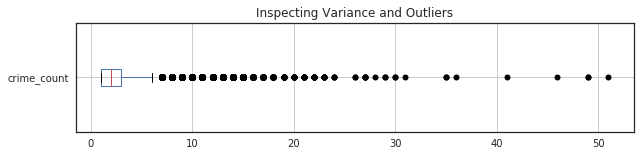

In [15]:
# Plot a boxplot to inspect variance and outliers
grouped_data[['crime_count']].boxplot(figsize=(10,2), sym='k', grid=True, vert=False)
plt.title('Inspecting Variance and Outliers')
plt.show()

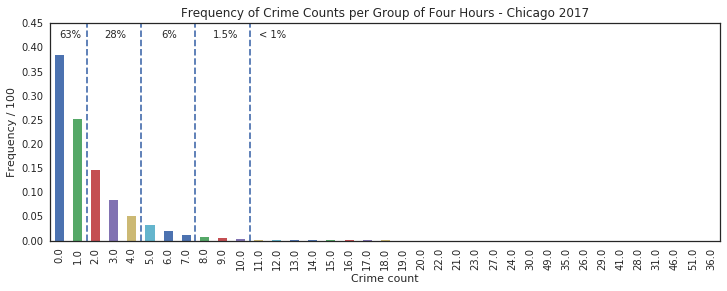

In [16]:
# create dataframe with the frequency of unique crime counts
crime_counts = pd.DataFrame(data=data.crime_count.value_counts())

# create a column with percentiles for each crime count
crime_counts['percentile'] = crime_counts.crime_count / data.crime_count.value_counts().sum()

# plot the crime counts and set axis lines at specific thresholds
ax = crime_counts.percentile.plot.bar(figsize=(12,4))
ax.set_ylim(0,.45)
plt.axvline(x=1.5, ls='--')
plt.axvline(x=4.5, ls='--')
plt.axvline(x=7.5, ls='--')
plt.axvline(x=10.5, ls='--')
plt.annotate('63%', xy=(0,.42))
plt.annotate('28%', xy=(2.5,.42))
plt.annotate('6%', xy=(5.6,.42))
plt.annotate('1.5%', xy=(8.5,.42))
plt.annotate('< 1%', xy=(11,.42))
plt.title('Frequency of Crime Counts per Group of Four Hours - Chicago 2017')
plt.ylabel('Frequency / 100')
plt.xlabel('Crime count')
plt.show()

## Create Instance Classes

We want to predict crime levels at any given time and Community Area. To do so, we need to define thresholds for 'high', 'medium', and 'low' crime levels.

Let us first define that an **'instance'** is a moment in space and time. More specifically, an instance is any given time period of four hours at one of the 77 Chicago Community Areas.

Historical instances will be classified according to their historical number of crime counts. The same classes will be used for "future" instances.

- **0 or 1 crimes - Low Crime -** 63.4% of historical instances from January/2017 to April/2018
- **2 to 4 crimes - Medium Crime  -** 28.1% of historical instances from January/2017 to April/2018
- **5 to 7 crimes - Medium High Crime -** 6.3% of historical instances from January/2017 to April/2018
- **8 to 10 crimes - High Crime -** 1.5% of historical instances from January/2017 to April/2018
- **11 or more crimes - Very High Crime -** less than 1% historical instances from January/2017 to April/2018

In [17]:
# create a column with null values
data['instance_clf'] = np.nan

# populate the column with instance class values according to thresholds
data.loc[data.crime_count<=1, ['instance_clf']] = 0 # 0 or 1
data.loc[(data.crime_count>1) & (data.crime_count<5), ['instance_clf']] = 1 # 2 to 4
data.loc[(data.crime_count>4) & (data.crime_count<8), ['instance_clf']] = 2 # from 5 to 7
data.loc[(data.crime_count>7) & (data.crime_count<11), ['instance_clf']] = 3 # from 8 to 10
data.loc[(data.crime_count>10), ['instance_clf']] = 4 # 11 or more

# cast the int64 data type to column
data.instance_clf = data.instance_clf.astype('int64')

## Time Series Analysis
The distribution of crime incidents varies widely among Community Areas. While on Community Area 09 (the safest) most of the instances report zero to one crime counts, Community Area 25 (the least safe) has on average seven crimes per group of four hours.

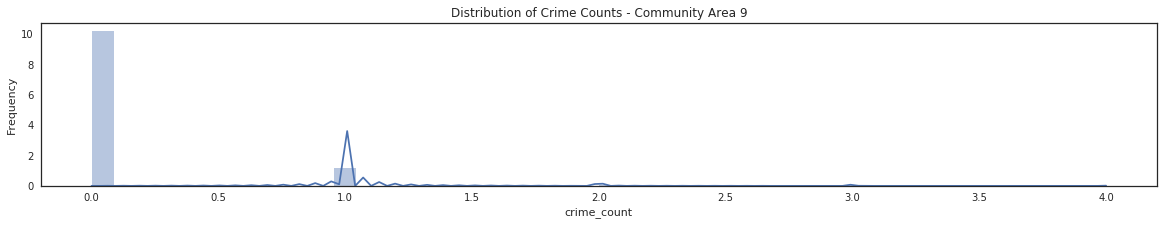

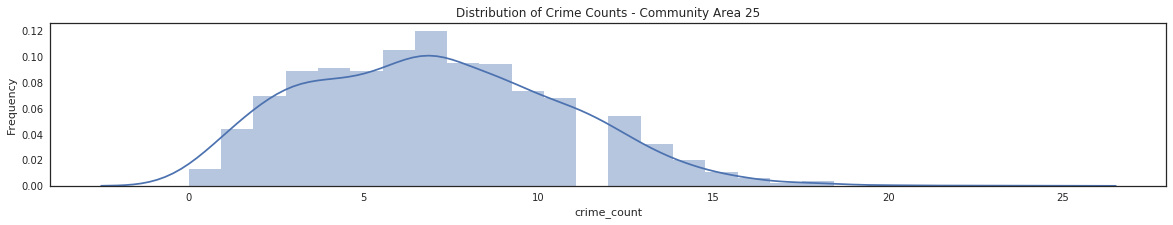

In [18]:
# iterate over two community areas and generate distribution plots
for i in [9,25]:
  plt.figure(figsize=(20,3))
  sns.distplot(data[(data.community_area==i) & (data.index.year==2017)].crime_count)
  plt.title('Distribution of Crime Counts - Community Area {}'.format(i))
  plt.ylabel('Frequency')
  plt.show()

Crime levels also vary by different times of the day, with 4 AM having the lowest crime rates, and 12 PM the highest, creating a pattern.

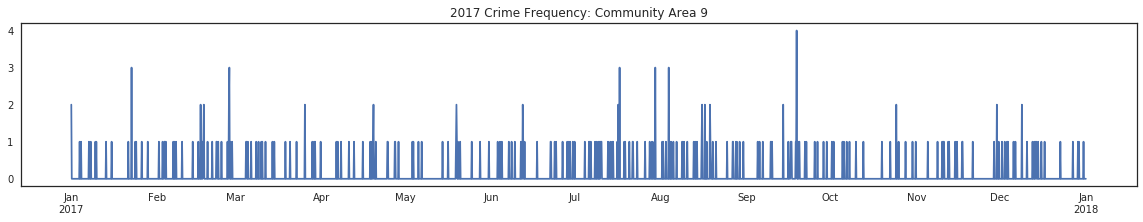

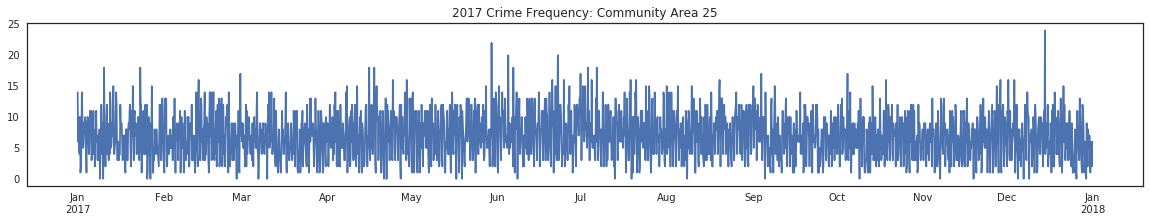

In [19]:
# iterate over two community areas and generate line plots
for i in [9,25]:
    data[(data.community_area==i) & (data.index.year==2017)].crime_count.plot(figsize=(20,3))
    plt.title('2017 Crime Frequency: Community Area {}'.format(i))
    plt.show()

The time series patterns in the data set indicate that the best results can be obtained by running our models with subsets of the data **for every Community Area and Time of The Day**. The plots below show how time series frequencies can be "smoothed out" by this approach.

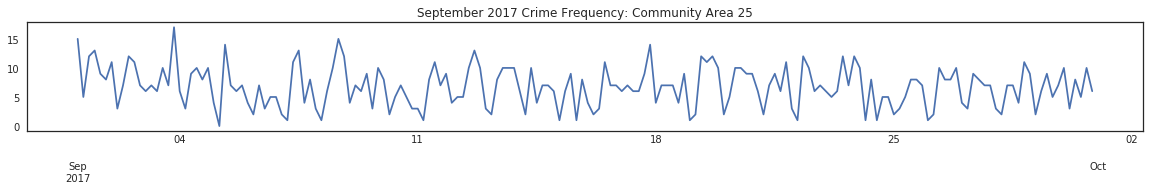

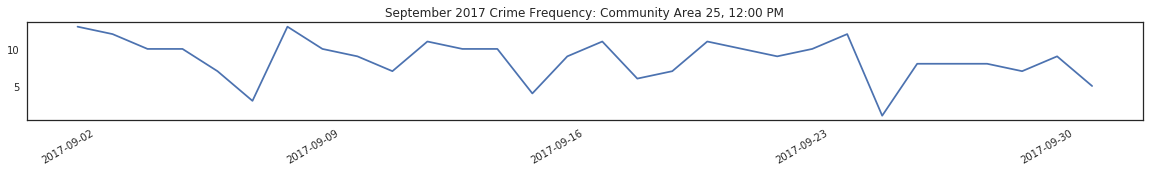

In [20]:
# generate line plot for specific community area and time frame
data[(data.community_area==25) & (data.index.year==2017) & (data.index.month==9)].crime_count.plot(figsize=(20,2))
plt.title('September 2017 Crime Frequency: Community Area 25')
plt.show()

# generate line plot for specific community area and time frame
data[(data.community_area==25) & (data.index.year==2017) & (
  data.index.month==9) & (data.index.hour==12)].crime_count.plot(figsize=(20,2))
plt.title('September 2017 Crime Frequency: Community Area 25, 12:00 PM')
plt.show()

### Create time ranking and "lag" features
To account for variation in time, each month and weekday are ranked according to their total crime counts in 2017.

'Lag' features are columns with time series data that is offsetted (or shifted) by a specific amount of time (e.g., -4h, or -24h).

Often, data is autocorrelated reflecting patterns within the time series due to seasonality and repeating frequencies. Specifically in Chicago, crime counts are autocorrelated with lag features of -24h, since crime is more frequent at specific times of the day.

In [10]:
# create an ordered list of unique community areas
community_area = sorted(list(data.community_area.unique()))
# convert list items to integer
community_area = [int(x) for x in community_area]

In [22]:
# create columns with null values
data['month_rkg'] = np.nan
data['weekday_rkg'] = np.nan

# iterate over dictionaries and populate columns with month and weekday ranking data
for i in community_area:

    for key, value in d['month_dict_{0}'.format(i)].items():
        data.loc[(data.community_area==i) & (data.index.month == key), ['month_rkg']] = value
        
    for key, value in d['weekday_dict_{0}'.format(i)].items():
        data.loc[(data.community_area==i) & (data.index.weekday == key), ['weekday_rkg']] = value

In [23]:
# create columns with lag data
data['lag_1'] = data['crime_count'].shift(1) # -4h
data['lag_2'] = data['crime_count'].shift(2) # -8h
data['lag_3'] = data['crime_count'].shift(3) # -12h
data['lag_4'] = data['crime_count'].shift(4) # -16h
data['lag_5'] = data['crime_count'].shift(5) # -20h
data['lag_6'] = data['crime_count'].shift(6) # -24h

data.fillna(1, inplace=True)

## Inspect and merge weather data
A few data points were missing in the weather data and were filled with the previous observation.

In [24]:
# create dictionary from dataframe
weather_dict = weather.to_dict()

# iterate over dictionary and create new columns
for weather_variable, variable_dict in weather_dict.items():
    data[weather_variable] = np.nan
    for key, value in variable_dict.items():
        data.loc[data.index==key, [weather_variable]] = value

# fix outlier/incorrect data
data['Wind Speed'] = data['Wind Speed'].apply(lambda x: 4.0 if x>400 else x)

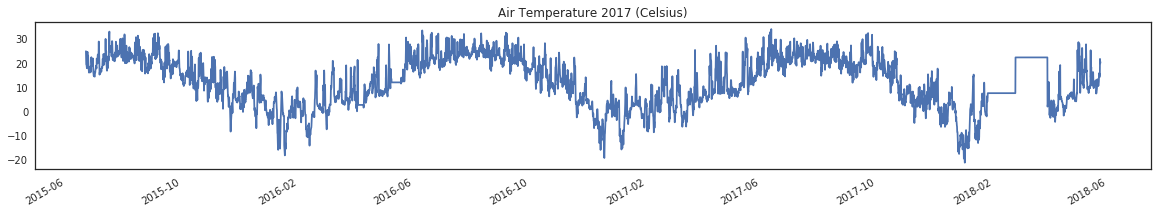

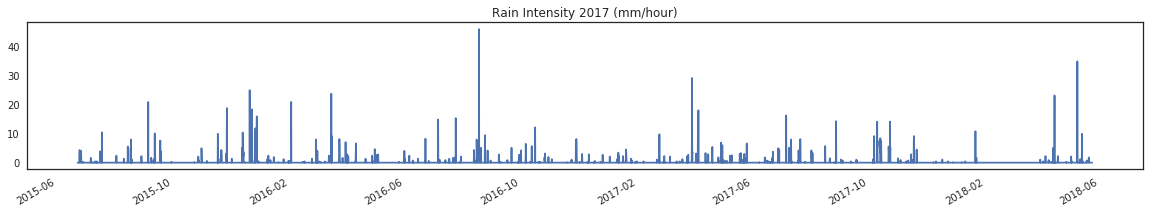

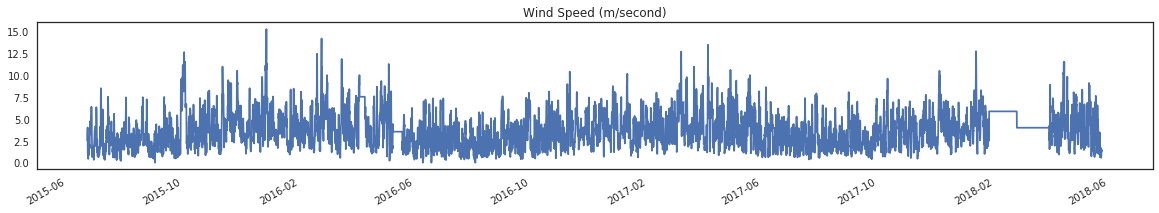

In [25]:
# plot air temperature, rain intensity and wind speed line charts
data['Air Temperature'].plot(figsize=(20,3), title='Air Temperature 2017 (Celsius)')
plt.show()
data['Rain Intensity'].plot(figsize=(20,3), title='Rain Intensity 2017 (mm/hour)')
plt.show()
data['Wind Speed'].plot(figsize=(20,3), title='Wind Speed (m/second)')
plt.show()

## Merge population data and inspect correlations

We'll finally merge the population data to our dataframe and inspect how all variables correlate.

In [26]:
# create dictionary from dataframe
pop_dict = scaled_pop_data.to_dict()

# iterate over dictionary and create new columns
for census_variable, variable_dict in pop_dict.items():
    data[census_variable] = np.nan
    for key, value in variable_dict.items():
        data.loc[data.community_area==key, [census_variable]] = value

# select specific columns
columns = ['Total Population', 'Median Age', 'Average Household Size', 'Vacant Housing Units', 'Renter occupied',
           'Median household income','Air Temperature', 'Rain Intensity', 'Wind Speed',
          'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'crime_count']

# generate a correlation matrix with selected columns
corr_matrix = data[columns].corr()

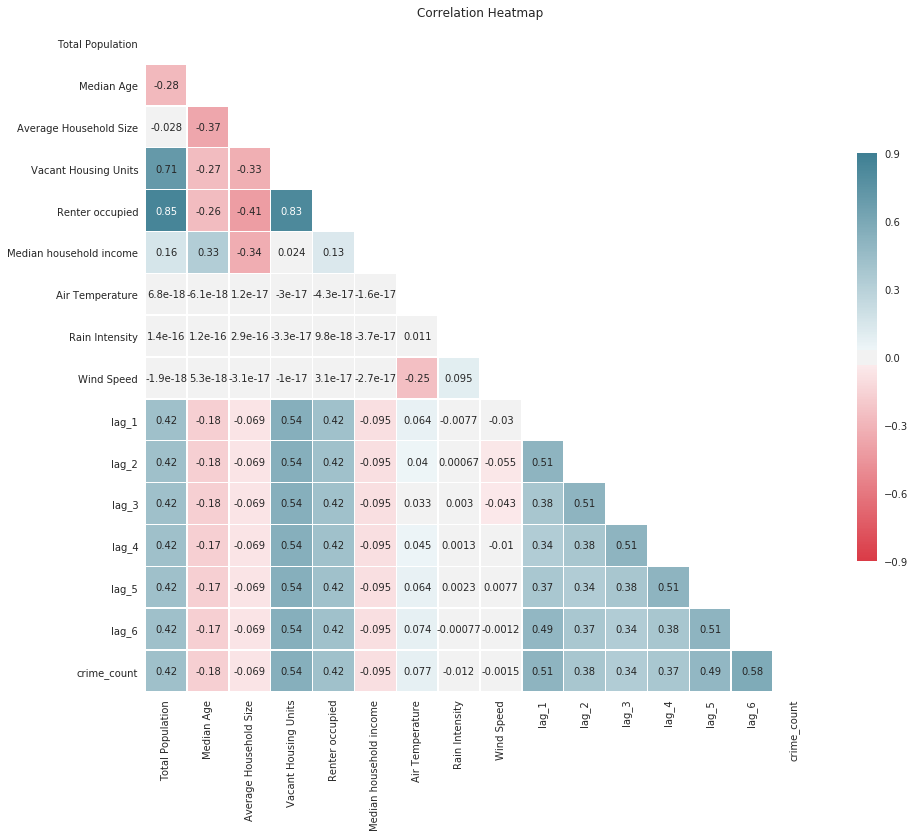

In [27]:
# Create a correlation heatmap
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix,
            mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.title('Correlation Heatmap')
plt.show()

Crime is mostly autocorrelated with the crime count observed in the same time of the previous day (r-squared 0.58). Crime is also highly correlated with the presence of vacant housing units (0.54) and total population (0.42).

The greater the median age, the lower the crime rates (r-squared -0.18) and to a lesser extent to higher household income (-0.095) and household size (-0.069), indicating that crime is less frequent in more affluent neighborhoods.

The variable 'Renter occupied' is nearly colinear to 'Total Population' and 'Vacant Housing Units' and will be dropped.

In [28]:
# save dataframe to CSV file
data.to_csv('data_with_pop.csv')

In [29]:
# delete demographic variables
cols = ['Renter occupied', 'Total Population', 'Average Household Size', 
        'Median Age', 'Vacant Housing Units', 'Median household income']
data.drop(columns=cols, inplace=True)

# Predicting Crime in Chicago

Since this is a **multiclass classification** problem, the following models are used to predict crime in Chicago:

- Bernoulli Naive Bayes
- Logistic Regression
- KNN Classifier
- Random Forest Classifier
- Gradient Boosting Classifier
- Support Vector Classifier

### Create the train and test data sets, and customized functions
The data is split by years: 
- Train data from June 2015 to May 2017
- Test data from June 2017 to May 2018

In [5]:
data = pd.read_csv('data.csv', index_col=0, parse_dates=True)
data.head(1)

,community_area,crime_count,instance_clf,month_rkg,weekday_rkg,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,Wind Speed,Rain Intensity,Air Temperature
2015-06-23,1,1.0,0,0.068196,0.139825,1.0,1.0,1.0,1.0,1.0,1.0,2.55,0.0,24.75


In [6]:
# create an ordered list of unique community areas
community_area = sorted(list(data.community_area.unique()))
# convert list items to integer
community_area = [int(x) for x in community_area]

In [7]:
# create train and test dataframes and split data by date
X_train = data.drop(columns=['crime_count', 'instance_clf'])
X_train = X_train[X_train.index < '2017-06-23 00:00:00']

y_train = data[['community_area', 'instance_clf']]
y_train = y_train[y_train.index < '2017-06-23 00:00:00']

X_test = data.drop(columns=['crime_count', 'instance_clf'])
X_test = X_test[X_test.index >= '2017-06-23 00:00:00']

y_test = data[['community_area', 'instance_clf']]
y_test = y_test[y_test.index >= '2017-06-23 00:00:00']

## Tuning Model Parameters

For each model, RandomizedSearchCV is used to randomly select and test several parameter combinations and select the most promising. 
The method also cross-validates each combination twice.

Each parameter combination was fit and scored using the *F1_micro* scoring method: $F1 = 2 * (precision * recall) / (precision + recall)$

The model's *Precision* is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The *Recall*, on the other hand, is the ratio tp / (tp + fn).

The F1-Score ranges from 1 (best) to 0 (worst). The relative contribution of precision and recall to the F1 score are equal. By setting F1 to 'micro', the scoring method ignores class imbalance and all classes are weighted equally.

The following custom function fits the RandomizedSearchCV method and enables multiprocessing on all CPU cores. The function saves a CSV file with all resulting parameter scores.

The resulting CSV files can be downloaded from [this link](https://github.com/ebadran/thinkfulBC/tree/master/U3/SML_capstone_parameter_tuning).

In [8]:
# Define a function to run RandomizedSearchCV
def randomized_cv(model, params, iterations, num_cv):

  # Declare randomized searpred_func CV
  random_CV = RandomizedSearchCV(estimator=model, param_distributions=params,
                    n_iter=iterations, verbose=5, cv=num_cv, n_jobs=-1, scoring='f1_micro')
  
  # Start the timer function
  start_time = time.time()
  
  # This "if" statement makes models run in the main program to prevent infinite multi-processing loops
  if __name__ == '__main__':
    multiprocessing.set_start_method('forkserver', force=True)

    # Fit the random searpred_func model
    random_CV.fit(X_train.iloc[:,1:], y_train.instance_clf)

    # Stop the timer function and inspect the time taken to run the method
    print("\n--- %s seconds ---" % (time.time() - start_time))

    # Store the results in a csv file
    results = pd.DataFrame(data= random_CV.cv_results_)
    filename_limit = str(model).find('(')
    filename = str(model)[:filename_limit]
    results.to_csv('CV_{}.csv'.format(filename))

    # Print the best parameters from RandomizedSearchCV
    print(random_CV.best_params_)

## Generating and Evaluating Model Predictions

The next custom function uses all cores to fit the models for every Community Area and time group. It also captures known exceptions (e.g., when the target train variable has only one sample) and saves a CSV file with predictions.

The models are fitted with the best parameters obtained from RandomizedSearchCV. Data was resampled and **models were fit for every district, and for every hour group (12AM, 4AM, 8AM, 12PM, 4PM, 8PM).**

The predictions are evaluated with the *Receiver Operating Characteristic Curve*, or ROC-Curve. Quoting Wikipedia:

    “A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a multi-class classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings."
    
The resulting CSV files can be downloaded from [this link](https://github.com/ebadran/thinkfulBC/tree/master/U3/SML_capstone_predictions).

In [9]:
# create a list of unique hours
hours = data.index.hour.unique()

# create a function to fit the models
def pred_func(model):

  # Start the timer function
  start_time = time.time()
  
  # This "if" statement makes models run in the main program to prevent infinite multi-processing loops
  if __name__ == '__main__':
    multiprocessing.set_start_method('forkserver', force=True)
    
    # instantiate a list to store score values for each community area
    score = []
    
    # create a dataframe to store predictions
    predictions = y_test.copy()
    predictions['prob_0'] = np.nan
    predictions['prob_1'] = np.nan    
    predictions['prob_2'] = np.nan
    predictions['prob_3'] = np.nan
    predictions['prob_4'] = np.nan

    # separately call and fit the model for every community area and hour
    for i in community_area:
        for j in hours:

            # create a try-catch loop to fit the models and capture exceptions
            try:
                # fit the model
                model.fit(
                  X_train.loc[(X_train.community_area==i) & (X_train.index.hour==j)].iloc[:,1:],
                          y_train.loc[(y_train.community_area==i) & (y_train.index.hour==j)].instance_clf)
                
                # generate probability estimates for every observation
                y_pred = model.predict_proba(
                  X_test.loc[(X_test.community_area==i) & (X_test.index.hour==j)].iloc[:,1:])

                # generate model scores and append to list
                score.append(model.score(
                    X_train.loc[(X_train.community_area==i) & (X_train.index.hour==j)].iloc[:,1:],
                          y_train.loc[(y_train.community_area==i) & (y_train.index.hour==j)].instance_clf))
                
                # store predictions on dataframe
                for k in range(len(y_pred.T)):


                      predictions.loc[(predictions.community_area==i) & (predictions.index.hour==j),
                                      ['prob_{}'.format(k)]] = y_pred.T[k]

            # catch situations when samples have a single class
            except Exception as e:

                # print exception name and community area
                print('\nException - Community Area:', i)
                print(e)
                                
                # if all samples are of a single class, append value of 1 (equivalent to 100% score) to score list
                score.append(1)
                
                # store the single class value in a variable
                unique_val = y_train.loc[(y_train.community_area==i) & (y_train.index.hour==j)].instance_clf.value_counts().index[0]
                
                # print the single class value
                print('y_train value counts:', unique_val)
                
                # fill class column with '1' probability score
                predictions.loc[(predictions.community_area==i) & (predictions.index.hour==j),
                                    ['prob_{}'.format(unique_val)]] = 1
                
                # delete exception variable
                del e

    # fill null values with zero
    predictions.fillna(value=0, inplace=True)
    
    # print model min, max, and mean scores
    print('\nMin model accuracy:', np.min(score))
    print('Max model accuracy:', np.max(score))
    print('Mean model accuracy:', np.mean(score))
    
    # plot ROC curves plot
    skplt.metrics.plot_roc(predictions.instance_clf,
                           predictions[['prob_0', 'prob_1', 'prob_2', 'prob_3', 'prob_4']],
                          figsize=(10,4))
    plt.show()

    # save predictions to a CSV file
    filename_limit = str(model).find('(')
    filename = str(model)[:filename_limit]
    predictions.to_csv('{}.csv'.format(filename))
    
  # Stop the timer function and inspect the time taken to run the method
  print("\n--- %s seconds ---" % (time.time() - start_time))
        
  return predictions

## Bernoulli Naive Bayes

The Naive Bayes Classifier is a simple and fast model. It applies the Bayes Probability Theorem and assumes that all variables are independent. The fit_prior parameter instructs the algorithm whether to learn class prior probabilities or not. If false, a uniform prior is used.

Since the outcome data has five possible classes, the Bernoulli Naive Bayes classifier is used, with fit_prior set to "True".


Min model accuracy: 0.32694938440492477
Max model accuracy: 0.9958960328317373
Mean model accuracy: 0.7211996849479749


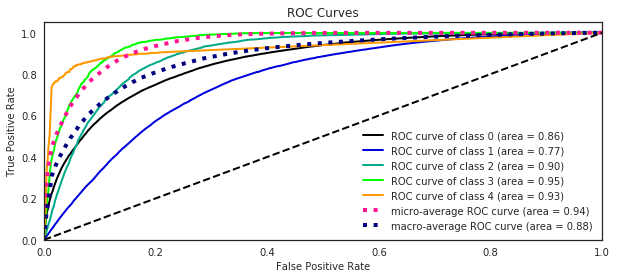


--- 50.13621401786804 seconds ---


In [33]:
# import the model module
from sklearn.naive_bayes import BernoulliNB

# Run classifier
model = BernoulliNB(alpha=10, fit_prior=True)

# call the prediction function
BNB = pred_func(model)

## Logistic Regression

Logistic regression can be used to calculate the probability (obtained as the log odds) of each specific crime level class.


Min model accuracy: 0.3761969904240766
Max model accuracy: 0.9958960328317373
Mean model accuracy: 0.7264081108130356


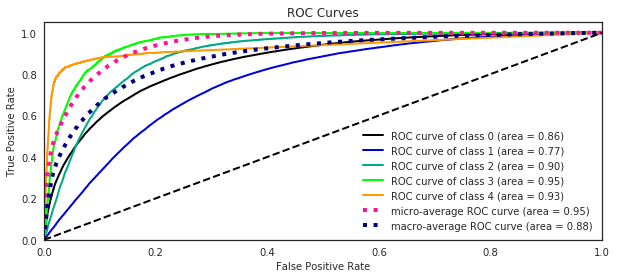


--- 108.55416536331177 seconds ---


In [34]:
# import the model module
from sklearn.linear_model import LogisticRegression

# instantiate the model
model = LogisticRegression(C=50, solver='liblinear', penalty='l1', fit_intercept=True)

# call the prediction function
lr = pred_func(model)

The selected 'l1' regularization parameter penalizes large coeficients by multiplying the sum of the absolute values of the coefficients by the value set in the 'C' parameter. Setting C=1 essentially makes the model a 'vanilla' logistic regression with no regularization.

With 'warm_start' the algorithm reuses the solution of the previous call to fit as initialization. With warm_start set to True, the predictions have a higher chance of overfitting.

The 'saga' solver algorithm parameter (stochastic average gradient descent) is an algorithm that has been successfully applied to large and sparse data sets. Saga scored 0.04 points lower than the default 'liblinear'.

## Knn Classifier
The KNN classification model sorts the 'K' number of most similar (or nearest) data points. Similarity is measured according to a proximity metric that can be defined in the model's parameters. The algorithm calculates the probability for each vote value $ \frac{votes_i}{k} $ and the value with highest probability is returned.


Min model accuracy: 0.506155950752394
Max model accuracy: 0.9958960328317373
Mean model accuracy: 0.7719574087563145


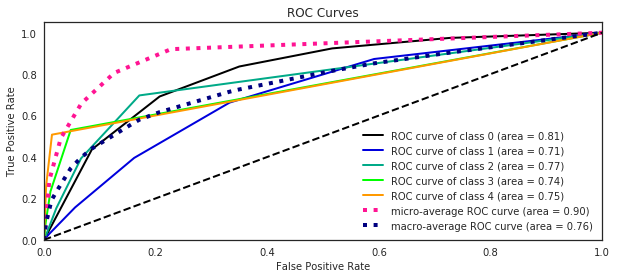


--- 60.22512650489807 seconds ---


In [ ]:
# import the model module
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model
model = KNeighborsClassifier(metric='euclidean', leaf_size=5, weights='uniform', algorithm='kd_tree', n_neighbors=5)

# call the prediction function
knn = pred_func(model)

The n_neighbors parameter was set to 5 (the same as the default). Increasing n_neighbors value has shown to decrease model scores.

The similarity metric changed from the default [Minkoswski Distance](http://www.code10.info/index.php%3Foption%3Dcom_content%26view%3Darticle%26id%3D61:articleminkowski-distance%26catid%3D38:cat_coding_algorithms_data-similarity%26Itemid%3D57) (which returns the distance along an axis on which two objects show the greatest absolute difference) to [Euclidean Distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) (which is the square root of the sum of the squared distances).

The selected algorithm is the [k-dimensional tree](http://pointclouds.org/documentation/tutorials/kdtree_search.php), which organizes data points into a k-number of dimensions according to their similarity. Finally, while the selected 'uniform' parameter weights all nearest points equally, as opposed to the 'distance' weighting parameter gives closer points greater influence. Distance weighting led to model overfitting.

## Random Forest Classifier
Random Forest is a 'bagging' ensemble model consisting of multiple decision trees. The trees are generated with randomly selected samples of the data, having varied depths (meaning varied numbers of leaves and branches). Trees get a "vote" on the outcome of each observation. The predictions with most votes are returned.


Min model accuracy: 0.6511627906976745
Max model accuracy: 0.9958960328317373
Mean model accuracy: 0.8407388325308981


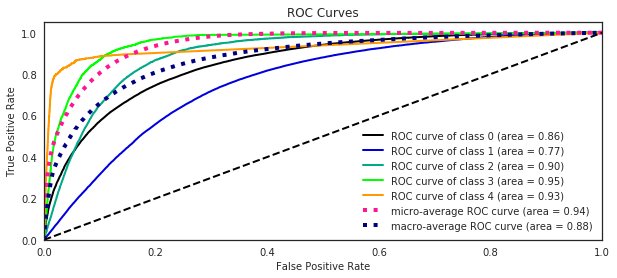


--- 128.36572074890137 seconds ---


In [36]:
# import the model module
from sklearn.ensemble import RandomForestClassifier

# instantiate the model
model = RandomForestClassifier(bootstrap=True, min_samples_leaf=5, min_samples_split=2, max_features='auto',
                               max_depth=None, n_estimators=100)
# call the prediction function
rfc = pred_func(model)

Max tree depth was set to 'None' to account for all possible variable combinations in the data set. Also, the number of estimators were set to 100, to increase randomness and prevent overfitting. Finally, bootstrap was set to True, meaning that sampling was made with replacement, increasing the chance of having representative samples and decreasing the chance of overfitting.

## Gradient Boosting
The gradient boosting classifier used here is an ensemble of "weak" decision trees that are run in sequence. The residuals of each decision tree is used as the outcome to be predicted by the subsequent tree. The cost function used is the sum of the negative log odds. Predictions are given by adding the values of all decision trees.


Min model accuracy: 0.6867305061559508
Max model accuracy: 1.0
Mean model accuracy: 0.8322880949419937


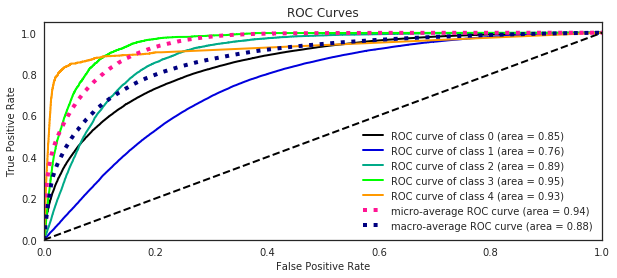


--- 123.36737084388733 seconds ---


In [37]:
# import the model module
from sklearn.ensemble import GradientBoostingClassifier

# instantiate the model
model = GradientBoostingClassifier(n_estimators=50, criterion='friedman_mse', max_depth=3, loss='deviance')

# call the prediction function
gbc = pred_func(model)

To prevent overfitting, weak decision trees were used, with max depth of 3 and the number of estimators of 100.
The “friedman_mse” criterion parameter is the function used to measure the quality of a split. It is the mean squared error modified specifically for gradient boosting.

The 'deviance' loss function is a probability estimate calculated by the negative log-odds ratio. The 'exponential' loss function is an estimator that gives greater weights to errors.

## Support Vector Machine Classifier
The Support Vector Machine Classifier (SVC) is an effective machine learning method for high dimensional spaces, including when the number of variables (or dimensions) exceeds the number of samples.

In SVC, the data is plotted as points in an n-dimensional space (with 'n' being the number of variables + the cost function). The term 'support vectors' refers to the vector coordinates of each data point. SVC finds the ideal boundary that differentiates the points into classes. The boundary consists of a hyperplane with an n-minus-one-dimension, that maximizes the sum of the distances between the boundary and the data points, while minimizing the cumulative distance of points on the wrong side of the margin.

It is a computationally expensive method that is considered highly effective for smaller data sets, but problematic on larger data sets. Finally, the SVC model calculates probability values using expensive five-fold cross-validation.


Min model accuracy: 0.7154582763337893
Max model accuracy: 0.9958960328317373
Mean model accuracy: 0.8504894558246131


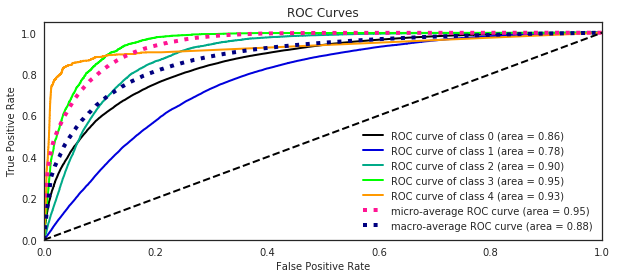


--- 135.41986465454102 seconds ---


In [38]:
# import the model module
from sklearn import svm
from sklearn.svm import SVC

# instantiate the model
model = svm.SVC(decision_function_shape='ovo', C=1, kernel='rbf', gamma='auto', probability=True)

# call the prediction function
svm_pred = pred_func(model)

The decision_function_shape was set to one-vs-one (OVO), where a separate classifier is trained for each pair of variables. This leads to N(N−1)/2 classifiers. OVO is recommended for imbalanced datasets but is more computationally expensive.

The kernel parameter is a function that computes how similar two vectors are. SVC's default 'rbf' radial basis function kernel computes the exponential function of the squared euclidean distance between two feature vectors multiplied by the negative gamma coefficient.

The RBF formula is K ( x, x' )  =  exp ( -γ || x-x' || ^2 )

The C parameter is the penalty for error (e.g., for a point being outside its boundary). Increasing either (or both) the C and the gamma values will increase the fitting of the boundary to the data, increasing the chances of overfitting.

### Multi Layer Perceptron Classifier

Multi-Layered Perceptron models (MLP) consist of multiple perceptron models that are run iteratively. Perceptrons models, in turn, are simple (or 'weak') classifiers that are similar to OLS regressions:

$$α+βX≥0:A$$
$$α+βX<0:B$$

where α is the shift, a way of regularizing the classification boundary to zero; and β is the weight, which controls the influence of each variable.

At each time step, the partial derivatives of the loss function are computed to update the parameters. Here we're using the *adam* solver parameter as our log-loss function, which is an optimized [stochastic gradient descent](https://www.quora.com/Whats-the-difference-between-gradient-descent-and-stochastic-gradient-descent) (SGD) function:

<img src='main-qimg-b45bf21d09e9762db1d21ab04330bcef.png'>

where η is the learning rate and *x* is the value of the observation.

The cost we are trying to minimize is the sum of the classifier error (e.g., each misclassified observations is assigned a value 1 = error).

The *hidden layer size* parameter defines the number and the size of our neural network layer. Each layer is comprised by a number of perceptron models.

The activation function determines whether the output from an individual perceptron is binary (parameter 'relu') or continuous (parameter 'logistic'). The logistic paramater is a sigmoid curve:

$$ \frac{1}{1+e^{-x}} $$
 
Using this parameter can increase prediction precision (and risk of overfitting) as well as computational costs.

Below we've tested both 'relu' and 'logistic' activation parameters with a neural network of three layers.


Min model accuracy: 0.307797537619699
Max model accuracy: 0.9958960328317373
Mean model accuracy: 0.7207170394584894


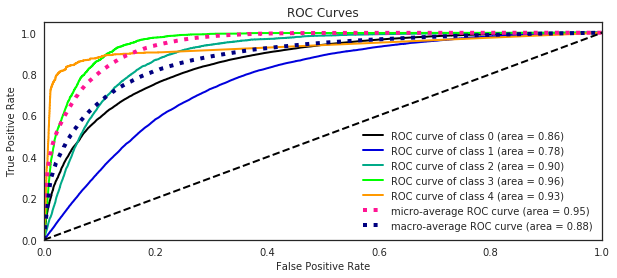


--- 524.7600610256195 seconds ---


In [10]:
from sklearn.neural_network import MLPClassifier

# instantiate the model
model = MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 1000, 100), solver='adam', alpha=.001)

# call the prediction function
mlp = pred_func(model)


Min model accuracy: 0.4801641586867305
Max model accuracy: 0.9958960328317373
Mean model accuracy: 0.8212879232031078


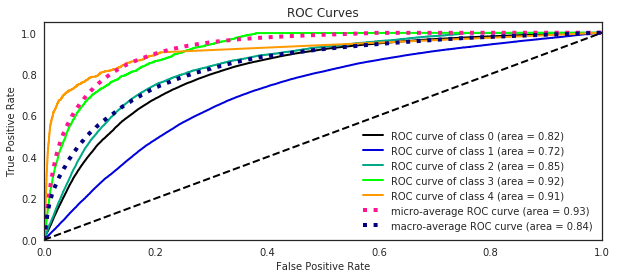


--- 844.6530921459198 seconds ---


In [12]:
from sklearn.neural_network import MLPClassifier

# instantiate the model
model = MLPClassifier(activation='relu', hidden_layer_sizes=(100, 1000, 100), solver='adam', alpha=.001)

# call the prediction function
mlp = pred_func(model)

# Conclusion and Next steps

The best results were obtained by similarity/difference models (SVC) and by decision trees models (Random Forest and Gradient Boosting). Meanwhile, Logistic Regression had reduced scores possibly due to the high level of autocorrelation in the data set.

Much of the criminology literature suggests that crime is concentrated in space and time. Our experiment analyzed the data based on Community Areas, which mostly cover large areas. As next steps, PostGIS can be used to create a grid of smaller "sectors" in Chicago, (e.g., areas in the city measuring 250 x 250 meters), and to sort crime data for each sector. This may help identify "crime hotspots" and possibly increase model utility and performance.